# 02. Neural Network classification with PyTorch

Classification is a problem of predicting whether something is one thing or another (there can be multiple things as the options).

Book version of this notebook - https://www.learnpytorch.io/02_pytorch_classification/


In [56]:
from torchinfo import summary

## 1. Make classification data and get it ready

In [57]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples=n_samples,
                    noise=.03,
                    random_state=42)

In [58]:
len(X), len(y)

(1000, 1000)

In [59]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [60]:
# Make DataFrame of circle data
import pandas as pd

circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


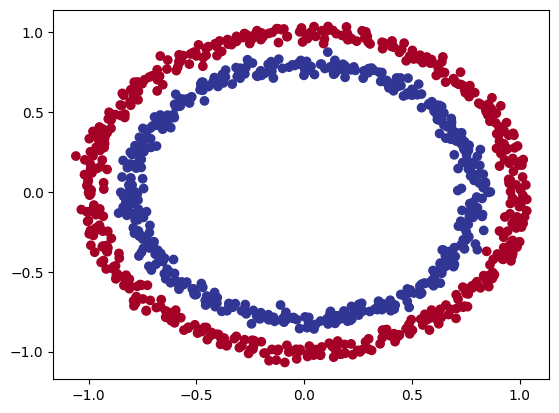

In [61]:
# Visualize, Visualize, Visualize
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

**Note**: The data we're working with is often referred to as a toy dataset, a dataset that is small enough to experiment but still sizable enough to practice the fundamentals.

### 1.1 Check input and output shapes

In [62]:
X.shape, y.shape

((1000, 2), (1000,))

In [63]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [64]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(F"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(F"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits

In [65]:
import torch
torch.__version__

'1.13.0+cu117'

In [66]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [67]:
# Turn data into tensors
# default float in pytorch is float32
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [68]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [69]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.2,  # .2=20% of data will be test & 80% will be train
                                                    random_state=42)

In [70]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agonistic code so our code will run on an accelerator (GPU) if there is one
2. Construct a model (by subclassing `nn.Module`)
3. Defining a loss function and optimizer
4. Create a training and test loop

In [71]:
# Import PyTorch and nn
import torch
from torch import nn

# Make device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [72]:
X_train.shape

torch.Size([800, 2])

Now we've setup device agnostic code, let's create a model that:

1. Subclasses `nn.Module` (almost all models in PyTorch subclass `nn.Module`)
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Defines a `forward()` method that outlines the forward pass (or forward computation) of the model
4. Instatiate an instance of our model class and send it to the target `device`

In [73]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handing the shapes of our data
        self.layer_1 = nn.Linear(in_features=2, out_features=5)  # takes in 2 features and upscales to 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1)  # takes in 5 features from previous layer and outputs a single feature (same shape as y)

    # 3. Define a forward() method that outlines the forward pass
    def forward(self, x):
        return self.layer_2(self.layer_1(x))  # x -> layer_1 -> layer_2 -> output


# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device=device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [74]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [75]:
# Let's replicate the model above using nn.Sequential()

model_0 = nn.Sequential(
    nn.Linear(in_features=2,
              out_features=5),
    nn.Linear(in_features=5,
              out_features=1)
).to(device)

summary(model_0)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Linear: 1-1                            15
├─Linear: 1-2                            6
Total params: 21
Trainable params: 21
Non-trainable params: 0

In [76]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]], device='cuda:0')),
             ('0.bias',
              tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]], device='cuda:0')),
             ('1.bias', tensor([-0.1213], device='cuda:0'))])

In [77]:
# Make predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(F"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(F"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(F"\nFirst 10 predictions:\n{torch.round(untrained_preds[: 10])}")
print(F"\nFirst 10 labels:\n {y_test[: 10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[-0.],
        [-0.],
        [0.],
        [-0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [-0.]], device='cuda:0')

First 10 labels:
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

Which loss function or optimizer should you use?

Again... this is problem specific.

For example for regression you might use MAE(Mean Absolute Error) or MSE(Mean Sqart Error).

For classification you might want binary cross entropy or categorical cross entropy(cross entropy).

As a reminder, ths loss function measure how *wrong* yours models predictions are.

And for optimizers, two of the most common and useful are SGD and Adam, however Pytorch has many built-in options.

* For some common choices of loss functions and optimizers:
  * https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html
* For the loss function we're going to use `torch.nn.BCEWithLogitsLoss()`, for more on what binary cross entropy(BCE) is, check out this aritcle:
  * https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
* For a definition on what a logit is in deep learning:
  * https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html
* For different optimizers see `torch.optim`

In [78]:
# Setup the loss function
# loss_fn = nn.BCELoss()  # BCELoss = requires inputes to have gone through the sigmoid activation function prior to input BCELoss
loss_fn = nn.BCEWithLogitsLoss()  # BCEWithLogitsLoss = sigmoid activation function built-in

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=.1)

In [79]:
# Calculate the accurcay - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

## 3. Train model

To train our model, we're going to build a training loop with the following steps:

1. Forward pass
2. Calculate the loss
3. Optimizer zero gradient
4. Backward (Backpropacation)
5. Optimizer step (gradient descent)

### 3.1 Going from raw logit -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logit**.

We can convert these **logit** into prediction probabilities by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multiclasses classification).

Then we can convert our model's prediction probabilitites to **prediction labels** by either rounding them or taking the `argmax()`. 

In [80]:
# View the first 5 outputs of the forward pass on the test data.
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]], device='cuda:0')

In [81]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [82]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities.
y_pred_prob = torch.sigmoid(y_logits)
y_pred_prob

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]], device='cuda:0')

For our prediction probability values, we need to perform a range-style rounding on them:
$$
\begin{cases}
\text{y\_pred\_prob} >= 0.5 & y=1 \text{ (class 1)} \\
\text{y\_pred\_prob} < 0.5 & y=0 \text{ (class 0)}
\end{cases}

$$

In [83]:
# Find the predicted labels
y_preds = torch.round(y_pred_prob)

# In full (logits -> prediction probabilities -> prediction labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extera dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 1., 0., 1.], device='cuda:0')

### 3.2 Building the training and testing loop

In [84]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of the epochs
epochs = 1000

# Put data to target device
X_train, y_train, X_test, y_test = tuple(map(lambda x: x.to(device), [X_train, y_train, X_test, y_test]))

# Build training and evaluation loop
for epoch in range(epochs):
    # Training
    model_0.train()

    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))  # turn logits -> pred prob -> pred labels

    # 2. Calculate loss / accuracy
    # loss = loss_fn(torch.sigmoid(y_logits),  # nn.BCELoss excepts prediction probabilities as input
    #                y_train)
    loss = loss_fn(y_logits,  # nn.BCEWithLogitLoss excepts raw logits as input
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero gradient
    optimizer.zero_grad()

    # 4. Backward (backpropagation)
    loss.backward()

    # 5. Optimize step (gradient descent)
    optimizer.step()

    # Testing
    with torch.inference_mode(mode=True):
        model_0.eval()
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate loss
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happend'
    if epoch % 10 == 0:
        print(F"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.5f} | Test loss: {test_loss:.5f}, Test acc {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69796, Accuracy: 51.87500 | Test loss: 0.69440, Test acc 58.00%
Epoch: 10 | Loss: 0.69590, Accuracy: 51.25000 | Test loss: 0.69305, Test acc 53.00%
Epoch: 20 | Loss: 0.69490, Accuracy: 51.62500 | Test loss: 0.69254, Test acc 49.50%
Epoch: 30 | Loss: 0.69435, Accuracy: 51.12500 | Test loss: 0.69236, Test acc 49.50%
Epoch: 40 | Loss: 0.69401, Accuracy: 50.87500 | Test loss: 0.69232, Test acc 51.00%
Epoch: 50 | Loss: 0.69378, Accuracy: 50.25000 | Test loss: 0.69234, Test acc 50.00%
Epoch: 60 | Loss: 0.69362, Accuracy: 50.00000 | Test loss: 0.69239, Test acc 51.50%
Epoch: 70 | Loss: 0.69351, Accuracy: 50.25000 | Test loss: 0.69246, Test acc 51.00%
Epoch: 80 | Loss: 0.69342, Accuracy: 49.87500 | Test loss: 0.69254, Test acc 50.00%
Epoch: 90 | Loss: 0.69336, Accuracy: 49.87500 | Test loss: 0.69262, Test acc 53.00%
Epoch: 100 | Loss: 0.69331, Accuracy: 49.25000 | Test loss: 0.69271, Test acc 53.00%
Epoch: 110 | Loss: 0.69327, Accuracy: 49.75000 | Test loss: 0.69279, Test ac

Epoch: 540 | Loss: 0.69299, Accuracy: 51.12500 | Test loss: 0.69429, Test acc 46.50%
Epoch: 550 | Loss: 0.69299, Accuracy: 50.87500 | Test loss: 0.69430, Test acc 46.50%
Epoch: 560 | Loss: 0.69299, Accuracy: 50.87500 | Test loss: 0.69432, Test acc 46.50%
Epoch: 570 | Loss: 0.69299, Accuracy: 50.87500 | Test loss: 0.69433, Test acc 46.50%
Epoch: 580 | Loss: 0.69299, Accuracy: 50.87500 | Test loss: 0.69434, Test acc 47.00%
Epoch: 590 | Loss: 0.69299, Accuracy: 51.00000 | Test loss: 0.69435, Test acc 46.50%
Epoch: 600 | Loss: 0.69299, Accuracy: 51.25000 | Test loss: 0.69436, Test acc 46.50%
Epoch: 610 | Loss: 0.69299, Accuracy: 51.12500 | Test loss: 0.69438, Test acc 46.50%
Epoch: 620 | Loss: 0.69299, Accuracy: 51.25000 | Test loss: 0.69439, Test acc 46.50%
Epoch: 630 | Loss: 0.69298, Accuracy: 51.25000 | Test loss: 0.69440, Test acc 46.00%
Epoch: 640 | Loss: 0.69298, Accuracy: 51.25000 | Test loss: 0.69441, Test acc 46.00%
Epoch: 650 | Loss: 0.69298, Accuracy: 51.25000 | Test loss: 0.694

## 4. Make predictions and evaluate the model

From the metrics it looks like our model isn't learning anything...

So to inspect it let's make some predictions and make them visual!

In other words, "Visualize, visualize, visualize!"

To do so, we're going to import a function called `plot_decision_boundary()`:
 * https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py

In [85]:
import requests
from pathlib import Path


# Download helper functions from Learn Pytorch repo (if it is not already downloaded)
if Path('helper_functions.py').is_file():
    print("helper_function.py already exists, skipping download")
else:
    print("Download helper_function.py")
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')

    with open('helper_function.py', 'wb') as f:
        f.write(request.content)

from helper_function import plot_predictions, plot_decision_boundary

Download helper_function.py


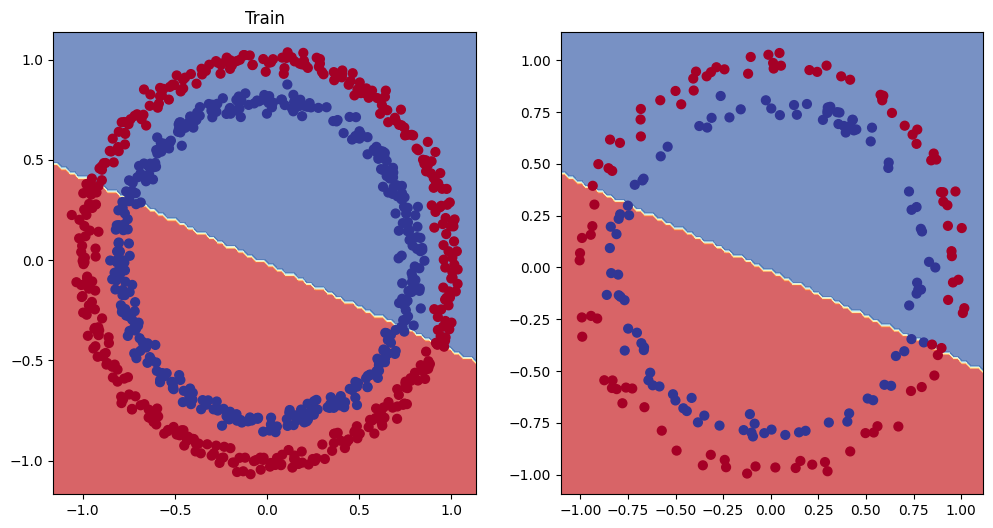

In [86]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model=model_0, X=X_train, y=y_train)

plt.subplot(1, 2, 2)
plot_decision_boundary(model=model_0, X=X_test, y=y_test)